In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import rescomp

import matplotlib.pyplot as plt
# import pyfftw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.executable

'C:\\Users\\Dennis\\anaconda3\\envs\\rc_env_np16p6\\python.exe'

### KS System:

In [ ]:
# KS system:
dimensions = 40
system_size = 30
def data_creation_function_KS(time_steps, dt, starting_point=None):
    sim_data = rescomp.simulate_trajectory(
            sys_flag='kuramoto_sivashinsky', dimensions=dimensions, system_size=system_size, dt=dt,
            time_steps=time_steps, starting_point = starting_point)
    return sim_data

def data_creation_function_KS_Bhatt(time_steps, dt, starting_point=None):
    sim_data = rescomp.simulations._kuramoto_sivashinsky_Bhatt(dimensions=dimensions, system_size=system_size, dt=dt,
                                                    time_steps=time_steps, starting_point=starting_point,
                                                    alpha=1, beta=1)
    return sim_data

In [ ]:
dt = 0.1
N = 100
tau = 5
T = 2
eps = 1e-6
m = 12

In [ ]:
same_starting_point = data_creation_function_KS(time_steps=1, dt=1, starting_point=None)[-1]

f1 = lambda x: data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]
f2 = lambda x: data_creation_function_KS_Bhatt(time_steps=2, dt=dt, starting_point=x)[-1]

In [ ]:
# original KS Sim:
lyapunov_exp, lyapunov_exp_convergence = rescomp.measures.iterator_based_lyapunov_spectrum(f1, 
                                                                                           starting_point=same_starting_point, 
                                                                                           T=T, 
                                                                                           tau=tau,
                                                  eps=eps, nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)

In [ ]:
# Bhatt KS Sim:
lyapunov_exp_B, lyapunov_exp_convergence_B = rescomp.measures.iterator_based_lyapunov_spectrum(f2, 
                                                                                               starting_point=same_starting_point,
                                                                                               T=T, 
                                                                                           tau=tau,
                                                  eps=eps, nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)

In [ ]:
print(lyapunov_exp)
plt.figure(figsize=(10,5))
for iteration in lyapunov_exp_convergence.T:
    plt.plot(iteration[20:])
plt.grid()

In [ ]:
print(lyapunov_exp_B)
plt.figure(figsize=(10,5))
for iteration in lyapunov_exp_convergence_B.T:
    plt.plot(iteration[20:])
plt.grid()

In [ ]:
delta_exp = lyapunov_exp_B - lyapunov_exp
print(delta_exp)
plt.figure(figsize=(10,5))
for iteration in np.abs(lyapunov_exp_convergence_B - lyapunov_exp_convergence).T:
    plt.plot(iteration[20:])
plt.grid()

# Test _kuramoto_sivashinsky_custom

In [ ]:
# Sweep:
precisions = [128, 64, 32, 16]
fft_types = ["numpy", "scipy", "pyfftw_np", "pyfftw_sc", "pyfftw_fftw"]

# Fixed:
starting_point=None
dimensions = 40
system_size = 30

# LE-Algo:
dt = 0.1
N = 100
tau = 10
T = 5
eps = 1e-6
m = 12

def create_ks_sim_func(fft_type, prec, dimensions, system_size):
    def data_creation_function(time_steps, dt, starting_point=None):
        return rescomp.simulations._kuramoto_sivashinsky_custom(dimensions, system_size, dt, time_steps, starting_point,
                                 precision=prec, fft_type=fft_type)
    return data_creation_function
                                                        
data_creation_functions_dict = {}
for prec in precisions:
    for fft_type in fft_types:
        data_creation_functions_dict[(prec, fft_type)] = create_ks_sim_func(fft_type, prec, dimensions, system_size)

In [ ]:
res_dict = {}

i = 1
for key, func in data_creation_functions_dict.items():
    print(i, key)
    i+=1
    f = lambda x: func(time_steps=2, dt=dt, starting_point=x)[-1]
    try:
        lyapunov_exp_res = rescomp.measures.iterator_based_lyapunov_spectrum(f, 
                                                                             starting_point, 
                                                                             T=T, 
                                                                             tau=tau,
                                                                             eps=eps, 
                                                                             nr_steps=N, 
                                                                             dt=dt, 
                                                                             return_convergence=True,
                                                                             nr_of_lyapunovs=m)
        res_dict[key] = lyapunov_exp_res
    except Exception as e:
        print("Error: ", e)
        res_dict[key] = e
    

In [ ]:
plt.figure(figsize=(15,7))

for key, val in res_dict.items():
    if type(val) == tuple:
        largest_le_index = np.argmax(val[0])
        largest_le_evol = val[1][:, largest_le_index]
        if np.isnan(largest_le_evol).any():
            msg = "nan"
            print(f"{key}, {msg}")
        plt.plot(largest_le_evol, label=key)
    else:
        print(f"{key}, error: {val}")

print("____\n others:")
plt.title("Largest Lyapunov exponent, evolution")
plt.xlabel("iterations of QR algorithm")
plt.legend()
plt.grid()

# Test _kuramoto_sivashinsky_custom 2

In [ ]:
def KS_LEs_literature(m, L):
    '''
    Arxiv: 1902.09651
    not sure how good
    '''
    LEs = np.zeros(m)
    for i in range(m):
        LEs[i] = 0.093 - 0.94*((i+1)- 0.39)/L
    return LEs
LEs = KS_LEs_literature(m=12, L=10)

plt.grid()
plt.axhline(0, c="k", linestyle ="--")
for y in lyapunov_exp_literature:
    plt.axhline(y, c="r", linestyle=":")
for y in LEs:
    plt.axhline(y, c="b", linestyle=":")

In [ ]:
# system_size = 36

# LE_literature_dict = {12: [0.003, -0]}

lyapunov_exp_literature = [0.08, 0.056, 0.014, 0.003, -0.003, -0.004, -0.021, -0.088, -0.160, -0.224, -0.309, -0.373]
KY_literature = 8.229

dt = 0.25
N = 100
tau = 2000
T = 2
eps = 1e-6
m = 12
system_size = 36
dimensions = 60

In [ ]:
def create_ks_sim_func(fft_type, prec, dimensions, system_size):
    def data_creation_function(time_steps, dt, starting_point=None):
        return rescomp.simulations._kuramoto_sivashinsky_custom(dimensions, system_size, dt, time_steps, starting_point,
                                 precision=prec, fft_type=fft_type)
    return data_creation_function

In [ ]:
data_creation_function_KS = create_ks_sim_func(fft_type="scipy", prec=32, dimensions=dimensions, system_size=system_size)

f = lambda x: data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]


In [ ]:
np.random.seed(1)
initial_condition = np.random.randn(dimensions)
# initial_condition = None

out = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point=initial_condition, T=T, tau=tau, eps=eps, 
                                                  nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)

In [ ]:
lyaps, lyaps_development = out

title = "KS, 12 most positive LEs, scipy 64"
plt.figure(figsize=(15, 10))

plt.title(title)
plt.xlabel("iterations of QR algorithm")
plt.ylabel(r"$\lambda_i$")
plt.plot(lyaps_development[:, :12])
plt.grid()
plt.axhline(0, c="k", linestyle ="--")
for i, y in enumerate(lyapunov_exp_literature):
    if i == 0:
        plt.axhline(y, c="r", linestyle=":", label="literature")
    else:
        plt.axhline(y, c="r", linestyle=":")

plt.legend()

In [ ]:
KY = rescomp.measures.KY_dimension(lyaps)
print(KY)

# check multiple initial conditions:

In [9]:
def create_ks_sim_func(fft_type, prec, dimensions, system_size, mode="normal"):
    if mode == "precision":
        def data_creation_function(time_steps, dt, starting_point=None):
            return rescomp.simulations._kuramoto_sivashinsky_custom(dimensions, system_size, dt, time_steps, starting_point,
                                     precision=prec, fft_type=fft_type)
    elif mode == "Bhatt":
        def data_creation_function(time_steps, dt, starting_point=None):
            return rescomp.simulations._kuramoto_sivashinsky_Bhatt(dimensions, system_size, dt, time_steps, starting_point)
    elif mode == "normal":
        def data_creation_function(time_steps, dt, starting_point=None):
            return rescomp.simulations._kuramoto_sivashinsky(dimensions, system_size, dt, time_steps, starting_point)
    
    return data_creation_function



In [53]:
lyapunov_exp_literature = [0.08, 0.056, 0.014, 0.003, -0.003, -0.004, -0.021, -0.088, -0.160, -0.224, -0.309, -0.373]

# PARAMETERS
dt = 0.25
N = 50# 10
tau = 100
T = 2
eps = 1e-8
m = 12
system_size = 36
dimensions = 40

### KS Precision changes:

In [54]:
# %%timeit
N_ens = 3
precisions = [32, 64]

out_dict = {x:np.zeros((N_ens, N, m)) for x in precisions}
for prec in precisions:
    np.random.seed(5)
    print(f"prec: {prec}")
    for n in range(N_ens):
        print(f"n: {n+1}")
    
        initial_condition = np.random.randn(dimensions)
        data_creation_function_KS = create_ks_sim_func(fft_type="scipy", prec=prec, dimensions=dimensions, 
                                                       system_size=system_size, mode="precision")
        
        def f(x):
            return data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]
        
        # f = lambda x: data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]
        
        out = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point=initial_condition, T=T, tau=tau, eps=eps, 
                                                  nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)
        out_dict[prec][n, :, :] = out[1]

prec: 32
n: 1
n: 2
n: 3
prec: 64
n: 1
n: 2
n: 3


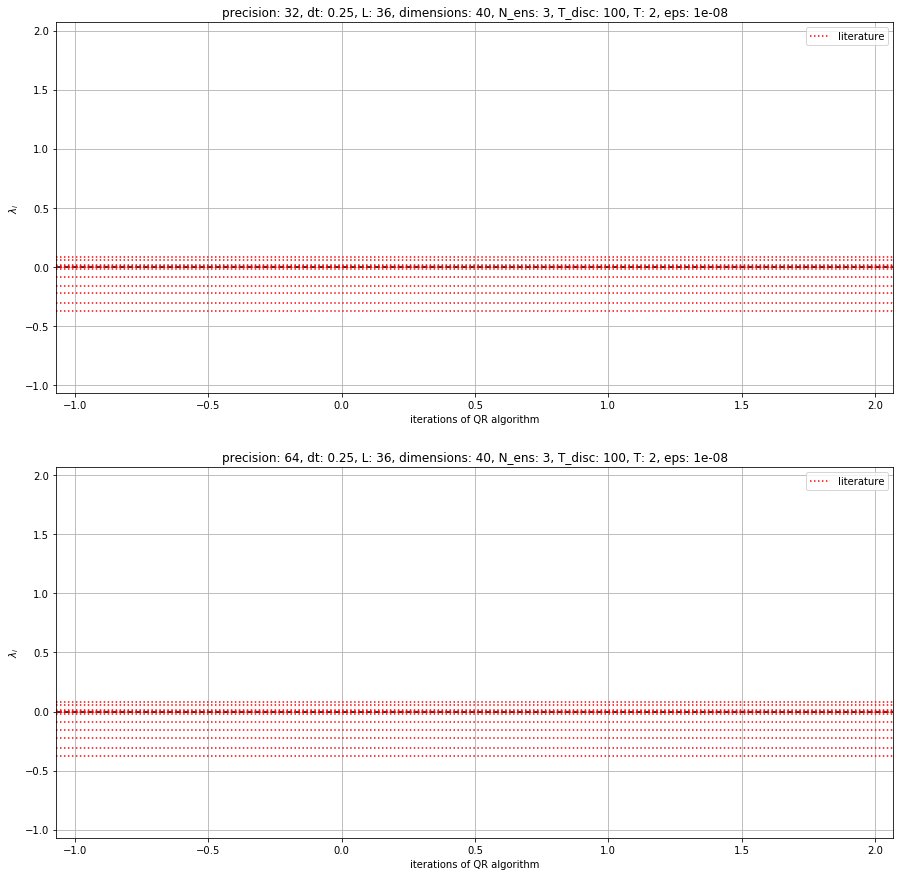

In [55]:
plt.figure(figsize=(15,15))

j = 0

for prec, val in out_dict.items():

    plt.subplot(2, 1, j+1)
    plt.title(f"precision: {prec}, dt: {dt}, L: {system_size}, dimensions: {dimensions}, N_ens: {N_ens}, T_disc: {tau}, T: {T}, eps: {eps}")
    plt.grid()
    avg = val.mean(axis=0)
    error = val.std(axis=0)
    for dim in range(m):
        plt.errorbar(x=np.arange(N), y=avg[:, dim], yerr=error[:, dim])
    plt.xlabel("iterations of QR algorithm")
    plt.ylabel(r"$\lambda_i$")
    plt.axhline(0, c="k", linestyle ="--")
    for i, y in enumerate(lyapunov_exp_literature):
        if i == 0:
            plt.axhline(y, c="r", linestyle=":", label="literature")
        else:
            plt.axhline(y, c="r", linestyle=":")
    
    plt.legend()
    j += 1

### Bhatt KS Simulation:

In [10]:
lyapunov_exp_literature = [0.08, 0.056, 0.014, 0.003, -0.003, -0.004, -0.021, -0.088, -0.160, -0.224, -0.309, -0.373]

# PARAMETERS
dt = 0.25
N = 100
tau = 1000
T = 2
eps = 1e-6
m = 12
system_size = 36
dimensions = 60

In [11]:
# %%timeit
N_ens = 3

result = np.zeros((N_ens, N, m))

np.random.seed(5)
for n in range(N_ens):
    print(f"n: {n+1}")

    initial_condition = np.random.randn(dimensions)
    data_creation_function_KS = create_ks_sim_func(None, None, dimensions, system_size, mode="Bhatt")

    def f(x):
        return data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]

    # f = lambda x: data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]

    out = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point=initial_condition, T=T, tau=tau, eps=eps, 
                                              nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)
    result[n, :, :] = out[1]

n: 1
n: 2
n: 3


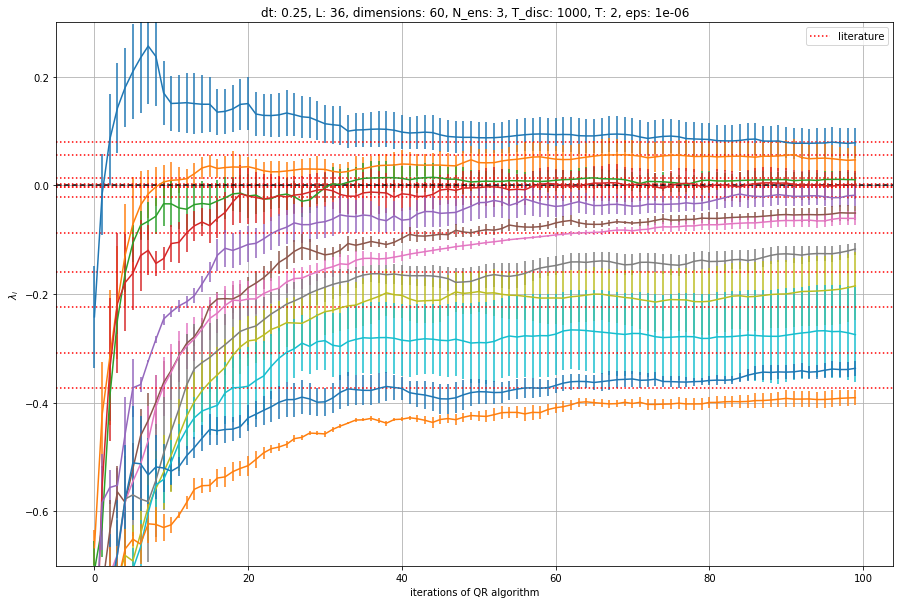

In [14]:
plt.figure(figsize=(15,10))

plt.title(f"dt: {dt}, L: {system_size}, dimensions: {dimensions}, N_ens: {N_ens}, T_disc: {tau}, T: {T}, eps: {eps}")
plt.grid()
avg = result.mean(axis=0)
avg = result[0, :]
error = result.std(axis=0)
for dim in range(m):
    plt.errorbar(x=np.arange(N), y=avg[:, dim], yerr=error[:, dim])
plt.xlabel("iterations of QR algorithm")
plt.ylabel(r"$\lambda_i$")
plt.axhline(0, c="k", linestyle ="--")
for i, y in enumerate(lyapunov_exp_literature):
    if i == 0:
        plt.axhline(y, c="r", linestyle=":", label="literature")
    else:
        plt.axhline(y, c="r", linestyle=":")
plt.ylim(-0.7, 0.3)
plt.legend()

### the "normal" KS Simulation:

In [58]:
# %%timeit
N_ens = 3

result = np.zeros((N_ens, N, m))

np.random.seed(5)
for n in range(N_ens):
    print(f"n: {n+1}")

    initial_condition = np.random.randn(dimensions)
    data_creation_function_KS = create_ks_sim_func(None, None, dimensions, system_size, mode="normal")

    def f(x):
        return data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]

    # f = lambda x: data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]

    out = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point=initial_condition, T=T, tau=tau, eps=eps, 
                                              nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)
    result[n, :, :] = out[1]

n: 1
n: 2
n: 3


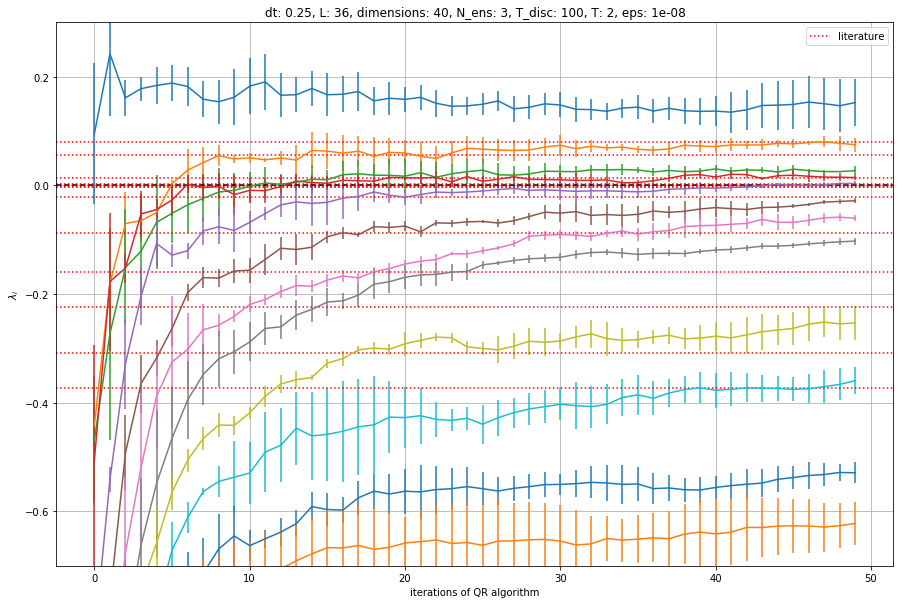

In [59]:
plt.figure(figsize=(15,10))

plt.title(f"dt: {dt}, L: {system_size}, dimensions: {dimensions}, N_ens: {N_ens}, T_disc: {tau}, T: {T}, eps: {eps}")
plt.grid()
avg = result.mean(axis=0)
error = result.std(axis=0)
for dim in range(m):
    plt.errorbar(x=np.arange(N), y=avg[:, dim], yerr=error[:, dim])
plt.xlabel("iterations of QR algorithm")
plt.ylabel(r"$\lambda_i$")
plt.axhline(0, c="k", linestyle ="--")
for i, y in enumerate(lyapunov_exp_literature):
    if i == 0:
        plt.axhline(y, c="r", linestyle=":", label="literature")
    else:
        plt.axhline(y, c="r", linestyle=":")
plt.ylim(-0.7, 0.3)
plt.legend()
